In [3]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,manifolds,geodesics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from mpl_toolkits.mplot3d import Axes3D

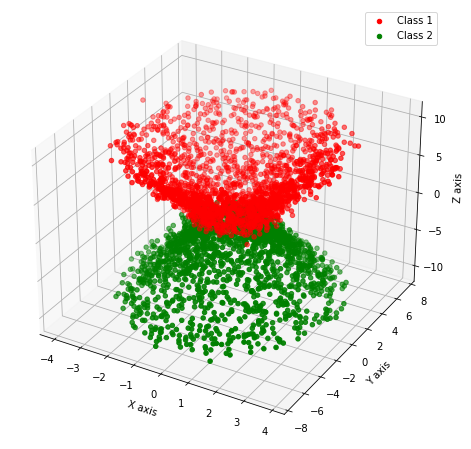

((4000, 3), (4000,))

In [93]:
def hyperboloid(a, b, c, min_z, max_z, size=100, noise=0.3):
    z = np.linspace(min_z, max_z, size)
    r = np.arcsinh(z/c)
    theta = np.random.uniform(0, 2*np.pi, size)
    x = a * np.cosh(r) * np.cos(theta)
    y = b * np.cosh(r) * np.sin(theta)
    # Adding some noise to the data
    x += np.random.normal(0, noise, size)
    y += np.random.normal(0, noise, size)
    z += np.random.normal(0, noise, size)
    return x, y, z

# Parameters for the hyperboloid
a, b, c = 1, 2, 3
size_per_class = 2000  # Number of points per class
z_min, z_max = -10, 10  # Range of z values

#Generate points for the hyperboloid (middle section, not a class itself)
x2, y2, z2 = hyperboloid(a, b, c, z_min, z_max, size=size_per_class)

# Generate points for class 1 (above the hyperboloid)
z1_min, z1_max = 0.1, z_max  # Slightly above the bottleneck to z_max
x1, y1, z1 = hyperboloid(a, b, c, z1_min, z1_max, size=size_per_class)

# Generate points for class 2 (below the hyperboloid)
z2_min, z2_max = z_min, -0.1  # z_min to slightly below the bottleneck
x2, y2, z2 = hyperboloid(a, b, c, z2_min, z2_max, size=size_per_class)


# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, color='r', label='Class 1')
ax.scatter(x2, y2, z2, color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((np.column_stack((x1, y1, z1)),
                          np.column_stack((x2, y2, z2)),))
                        #   np.column_stack((x3, y3, z3))))
y_data = np.array([1]*size_per_class + [2]*size_per_class)#+ [3]*size_per_class)

# Return dataset and labels
X_data.shape, y_data.shape

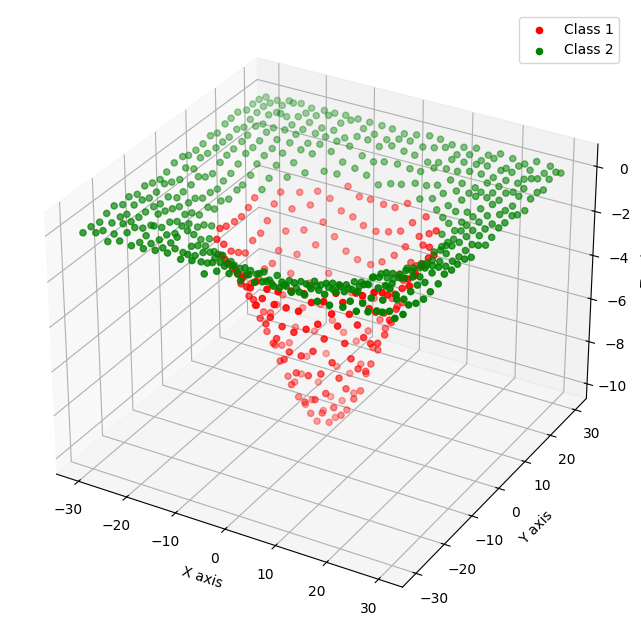

(676, 3)
(676,)


In [30]:
def gaussian_bell_3d(mu, sigma, size=1000, noise=0.1):
    # Create a grid of points
    x = np.linspace(-3*sigma, 3*sigma, int(np.sqrt(size)))
    y = np.linspace(-3*sigma, 3*sigma, int(np.sqrt(size)))
    x, y = np.meshgrid(x, y)
    x = x.ravel()
    y = y.ravel()
    # Calculate the z values on the bell curve
    z = -np.exp(-((x - mu)**2 + (y - mu)**2) / (2 * sigma**2))

    # Add noise
    x += np.random.normal(0, noise, x.shape)
    y += np.random.normal(0, noise, y.shape)
    z += np.random.normal(0, noise/10, z.shape)  # Less noise in the z to maintain the bell shape

    return x, y, z*sigma

# Parameters for the 3D Gaussian bell
mu = 0  # Mean of the distribution
sigma = 10  # Standard deviation of the distribution

# Generate points for the Gaussian bell
x, y, z = gaussian_bell_3d(mu, sigma, size=700)

# Define the top part of the bell as one class and the rest as another
# Assume the top part is above a certain z threshold, arbitrarily chosen here as 0.5
# Classify points based on their z value (threshold at 0.5 of the max z value)

threshold = min(z) * 0.15
above_mask = z < threshold
below_mask = z >= threshold


x1, y1, z1 = x[above_mask], y[above_mask], z[above_mask]

x2, y2, z2 = x[below_mask], y[below_mask], z[below_mask]


# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, color='r', label='Class 1')
ax.scatter(x2, y2, z2, color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((np.column_stack((x1, y1, z1)),
                    np.column_stack((x2, y2, z2)),))
y_data = np.array([1]*len(x1) + [2]*len(x2))

# Return dataset and labels
print(X_data.shape)
print(y_data.shape)

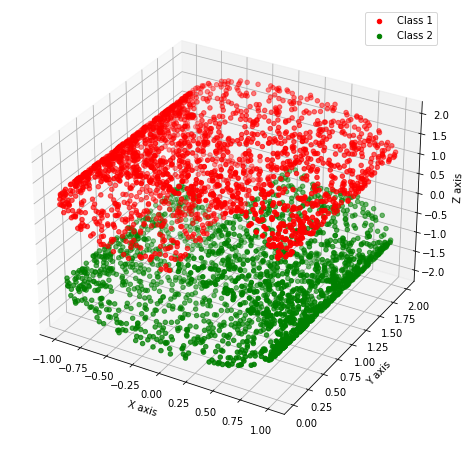

(4000, 3)
(4000,)


In [3]:
from sklearn import datasets, manifold
n_samples = 4000
S_points, _ = datasets.make_s_curve(n_samples, random_state=0)
above_mask = S_points[:,2] < 0
below_mask = S_points[:,2] >= 0
class1 = S_points[below_mask]
class2 = S_points[above_mask]

# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class1[:,0],class1[:,1],class1[:,2], color='r', label='Class 1')
ax.scatter(class2[:,0],class2[:,1],class2[:,2], color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((class1,class2))
y_data = np.array([1]*len(class1) + [2]*len(class2))

# Return dataset and labels
print(X_data.shape)
print(y_data.shape)

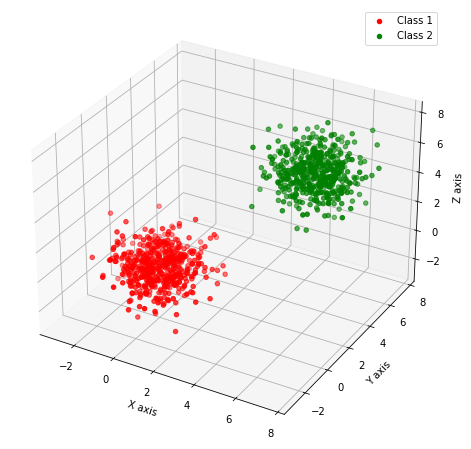

(1000, 3)
(1000,)


In [94]:
np.random.seed(0)  # For reproducibility

# Parameters for the first cluster
mean1 = [0, 0, 0]
cov1 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# Parameters for the second cluster
mean2 = [5, 5, 5]
cov2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# Generate points for each cluster
class1 = np.random.multivariate_normal(mean1, cov1, 500)
class2 = np.random.multivariate_normal(mean2, cov2, 500)


# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class1[:,0],class1[:,1],class1[:,2], color='r', label='Class 1')
ax.scatter(class2[:,0],class2[:,1],class2[:,2], color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((class1,class2))
y_data = np.array([1]*len(class1) + [2]*len(class2))

# Return dataset and labels
print(X_data.shape)
print(y_data.shape)

In [95]:
# Vérifie si CUDA (GPU support) est disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU est disponible. Device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU non disponible, utilisation du CPU")

GPU est disponible. Device: NVIDIA GeForce RTX 2070


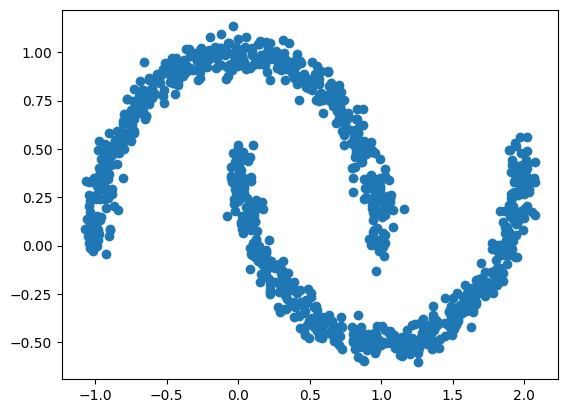

In [138]:
from sklearn import datasets, manifold, cluster

n_samples = 1000
moons, _ = datasets.make_moons(n_samples, random_state=0,noise=0.05)

plt.scatter(moons[:,0],moons[:,1])
X_data = moons

X_data = normalize(X_data)
test = cluster.AgglomerativeClustering(n_clusters=2, linkage='single')
test.fit(X_data)
y_data = test.labels_

In [31]:
# # initiliiaz min3d
# min3d = np.array([X_data[:,0].min(), X_data[:,1].min(), X_data[:,2].min()])
# max3d = np.array([X_data[:,0].max(), X_data[:,1].max(), X_data[:,2].max()])

# # function to normalize or unormalize data
# def normalize(X, min3d, max3d):
#     X2 = np.empty_like(X)
#     X2[:,0] = (X[:,0] - min3d[0])/(max3d[0] - min3d[0])
#     X2[:,1] = (X[:,1] - min3d[1])/(max3d[1] - min3d[1])
#     X2[:,2] = (X[:,2] - min3d[2])/(max3d[2] - min3d[2])
#     return X2

# def unnormalize(X, min3d, max3d):
#     X2 = np.empty_like(X)
#     X2[:,0] = X[:,0]*(max3d[0] - min3d[0]) + min3d[0]
#     X2[:,1] = X[:,1]*(max3d[1] - min3d[1]) + min3d[1]
#     X2[:,2] = X[:,2]*(max3d[2] - min3d[2]) + min3d[2]
#     return X2

# initiliiaz min3d
min3d = np.array([X_data[:,0].min(), X_data[:,1].min()])
mean3d = np.array([X_data[:,0].mean(), X_data[:,1].mean()])
std3d = np.array([X_data[:,0].std(), X_data[:,1].std()])

# function to normalize or unormalize data
"""
def normalize(X, min3d, max3d):
    X2 = np.empty_like(X)
    X2[:,0] = (X[:,0] - min3d[0])/(max3d[0] - min3d[0])
    X2[:,1] = (X[:,1] - min3d[1])/(max3d[1] - min3d[1])
    #X2[:,2] = (X[:,2] - min3d[2])/(max3d[2] - min3d[2])
    return X2
"""
def normalize(X):
    X2 = np.empty_like(X)
    mean3d = np.array([X[:,i].mean() for i in range(X2.shape[1])])
    X2 = X - mean3d
    max_3d = np.array([np.max(np.abs(X2[:, i])) for i in range(X2.shape[1])])
    X2 = X2/max_3d
    return X2

def unnormalize(X, min3d, max3d):
    X2 = np.empty_like(X)
    X2[:,0] = X[:,0]*(max3d[0] - min3d[0]) + min3d[0]
    X2[:,1] = X[:,1]*(max3d[1] - min3d[1]) + min3d[1]
    #X2[:,2] = X[:,2]*(max3d[2] - min3d[2]) + min3d[2]
    return X2


# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class HyperboloidDataset(Dataset):
    def __init__(self, points, labels):
        # Extract only the data with the specified labels
        self.data = []
        points = torch.tensor(points, dtype=torch.float32)
        for point,label in zip(points,labels):
            self.data.append((point,label))

        self.points = [point for point, label in self.data]
        self.targets = [label for point, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

X_data = normalize(X_data)
train_dataset = HyperboloidDataset(X_data, y_data)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

In [32]:
# TEST Théo
input_dim = train_dataset[0][0].shape[-1]  # The dimension of the data
hidden_dims = [64, 32]  # The dimension of the hidden layers
latent_dim = 2  # The latent space dimension
hidden_activation = nn.Tanh()  # The activation function of the hidden layers
encoder_output_mu_activation = nn.Identity() # Activation of the output of mu by the encoder
encoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the encoder
decoder_output_mu_activation = nn.Tanh() # Activation of the output of mu by the decoder
decoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the decoder

# optimizer
#lambda_reg = 1e-7 # weight decay (l2 regulariztaion to the loss)
learning_rate = 1e-3 #1e-3

# training
#warmup = int(0.3 * epochs)
epochs = 200 #

In [33]:
# initilize model
model = VAE.VAE(input_dim, 
                hidden_dims, 
                latent_dim, 
                hidden_activation, 
                encoder_output_mu_activation,
                encoder_output_logvar_activation,
                decoder_output_mu_activation,
                decoder_output_logvar_activation)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

VAE(
  (encoder): VAE_encoder(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Identity()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): VAE_decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=64, out_features=3, bias=True)
      (1): Tanh()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=64, out_features=3, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
)


[Epoch: 0/200] [objective loss: 3.138]
Reconstruction loss: 2.226562023162842
KL divergence loss: 0.13086268305778503
[Epoch: 20/200] [objective loss: 0.408]
Reconstruction loss: 0.48857247829437256
KL divergence loss: 0.0006423890590667725
[Epoch: 40/200] [objective loss: 0.396]
Reconstruction loss: 0.2813926339149475
KL divergence loss: 0.00040628015995025635
[Epoch: 60/200] [objective loss: 0.398]
Reconstruction loss: 0.43948352336883545
KL divergence loss: 0.0003640800714492798
[Epoch: 80/200] [objective loss: 0.401]
Reconstruction loss: 0.4675246775150299
KL divergence loss: 0.00023411214351654053
[Epoch: 100/200] [objective loss: 0.396]
Reconstruction loss: 0.3814826011657715
KL divergence loss: 0.00019726157188415527
[Epoch: 120/200] [objective loss: 0.405]
Reconstruction loss: 0.5930088758468628
KL divergence loss: 0.00019377470016479492
[Epoch: 140/200] [objective loss: 0.392]
Reconstruction loss: 0.1967795044183731
KL divergence loss: 0.0001287311315536499
[Epoch: 160/200] [o

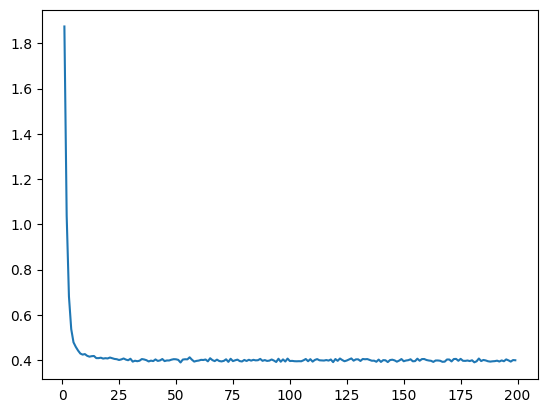

In [34]:
# Train the VAE with the new prior
ELBO_loss = []
for epoch in range(epochs):
    # Initialize the losses
    train_loss = 0.0

    for X_batch,y_batch in train_loader:
        # Forward pass
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = model(X_batch)

        # Compute the regluarization parameter for the warmup
        # that forces the latent variables to follow the prior distribution
        # see the code of VAE_loss for more informations
        #r = min(1.0, epoch / warmup) if warmup > 0 else 0.0 

        # The VAE loss
        # loss = VAE.VAE_loss(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
        #                                 mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, r=r)
        loss,reconstruction,kldiv = VAE.VAE_loss_2(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                        mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average loss for the epoch
    average_epoch_loss = train_loss / len(train_loader)
    ELBO_loss.append(average_epoch_loss)

    if epoch % 20 == 0:
        print(f"[Epoch: {epoch}/{epochs}] [objective loss: {average_epoch_loss:.3f}]")
        print(f"Reconstruction loss: {reconstruction}")
        print(f"KL divergence loss: {kldiv}")
    
ELBO_train = round(ELBO_loss[-1], 2)
print(f'[ELBO train: {ELBO_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, epochs), ELBO_loss[1:])
# plt.xlabel('Epochs')
# plt.ylabel('ELBO Loss')
plt.show()

In [35]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)



# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

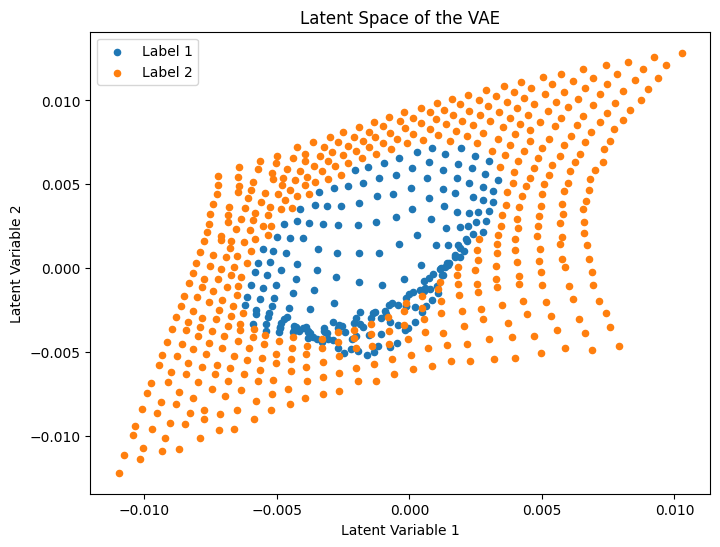

In [36]:
utils.plot_latent_space(latent_means,labels)

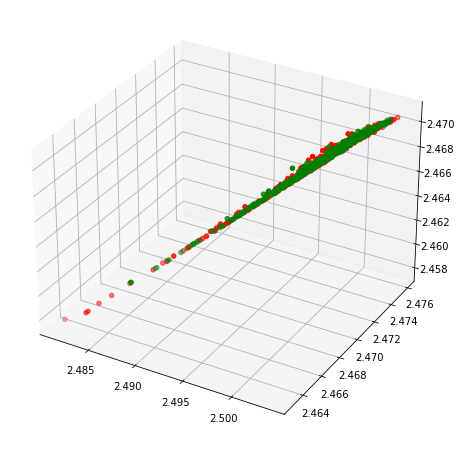

In [101]:
# see predictions
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
class1 = unnormalize(output_means[labels==1], min3d, max3d)
class2 = unnormalize(output_means[labels==2], min3d, max3d)
ax.scatter(class1[:,0],class1[:,1],class1[:,2], color='r', label='Class 1')
ax.scatter(class2[:,0],class2[:,1],class2[:,2], color='g', label='Class 2')

Apply Kmeans to the latent space


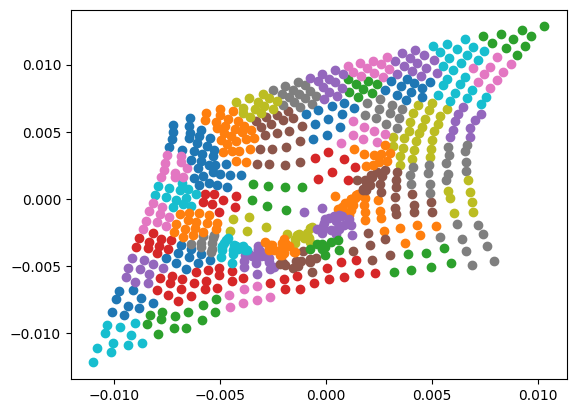

Compute the bandwidths for each centroids


In [37]:
# create RBF network
k_rbf = 64 #64
a = 2 #2
zeta_rbf = 1e-6 #1e-6
rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# apply kmeans to the means of the latent space
print("Apply Kmeans to the latent space")
plt.figure()
centers_rbf,centers_ids = rbfnn.fit_kmeans(latent_means,display=True)
# compute the bandwidths for each centroids
print("Compute the bandwidths for each centroids")
lambdas_k = rbfnn.compute_bandwidth(latent_means)

[iter: 0/1000] [objective loss: 2.616241]
[iter: 20/1000] [objective loss: 2.085890]
[iter: 40/1000] [objective loss: 1.799535]
[iter: 60/1000] [objective loss: 1.565746]
[iter: 80/1000] [objective loss: 1.419446]
[iter: 100/1000] [objective loss: 1.259391]
[iter: 120/1000] [objective loss: 1.106808]
[iter: 140/1000] [objective loss: 1.039559]
[iter: 160/1000] [objective loss: 0.941223]
[iter: 180/1000] [objective loss: 0.860189]
[iter: 200/1000] [objective loss: 0.787507]
[iter: 220/1000] [objective loss: 0.692642]
[iter: 240/1000] [objective loss: 0.654085]
[iter: 260/1000] [objective loss: 0.616769]
[iter: 280/1000] [objective loss: 0.542692]
[iter: 300/1000] [objective loss: 0.508806]
[iter: 320/1000] [objective loss: 0.461333]
[iter: 340/1000] [objective loss: 0.430097]
[iter: 360/1000] [objective loss: 0.405748]
[iter: 380/1000] [objective loss: 0.373525]
[iter: 400/1000] [objective loss: 0.384065]
[iter: 420/1000] [objective loss: 0.338732]
[iter: 440/1000] [objective loss: 0.31

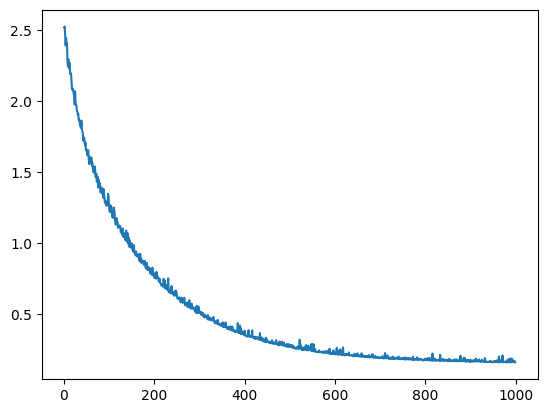

In [38]:
RBF_loss = []
nb_iters=1000
optimizer_rbf = torch.optim.Adam(rbfnn.parameters(), lr=2e-4, weight_decay=1e-7)

for iter in range(nb_iters):
    # Initialize the losses
    train_loss = 0.0

    permutation = np.random.permutation(len(train_dataset))

    for i in range(0, len(train_dataset), batch_size):
        # Forward pass in the model
        indices = permutation[i:i + batch_size]
        # get previously computed latent means and logvars
        LOG_VAR_X = output_logvars[indices, :]
        MU_Z = latent_means[indices, :]
 
        # Regress the output of the variance network
        LOG_VAR_X_eval_RBF = -torch.log(rbfnn(MU_Z)) # = log(1/beta_psi(z)) to have logvar

        loss = torch.nn.MSELoss(reduction='mean')(LOG_VAR_X, LOG_VAR_X_eval_RBF)
             
        # Backward pass
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()

        # Ensure positivity of the weights
        rbfnn.W_rbf.data.clamp_(min=1e-5)
        train_loss += loss.item()

    # Average loss for the iter
    average_iter_loss = train_loss / len(train_loader)
    RBF_loss.append(average_iter_loss)

    if iter % 20 == 0:
        print(f"[iter: {iter}/{nb_iters}] [objective loss: {average_iter_loss:.6f}]")
    
RBF_train = round(RBF_loss[-1],6)
print(f'[ELBO train: {RBF_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, nb_iters), RBF_loss[1:])
plt.show()

In [39]:
# combine both model into one torch module
vae_rbf_model = VAE_RBF.VAE_RBF(model,rbfnn)
torch.save(vae_rbf_model.state_dict(), 'torch_models/toydata_vaerbfnn.pt')

In [40]:
# load the saved model
"""input_dim = train_dataset[0][0].shape[-1]
hidden_dims = [8, 4]
latent_dim = 2
hidden_activation = nn.Tanh()
encoder_output_mu_activation=nn.Identity()
encoder_output_logvar_activation=nn.Softplus()
decoder_output_mu_activation=nn.Sigmoid()
decoder_output_logvar_activation=nn.Softplus()"""


# TEST Théo
input_dim = train_dataset[0][0].shape[-1]  # The dimension of the data
hidden_dims = [64, 32]  # The dimension of the hidden layers
latent_dim = 2  # The latent space dimension
hidden_activation = nn.Tanh()  # The activation function of the hidden layers
encoder_output_mu_activation = nn.Identity() # Activation of the output of mu by the encoder
encoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the encoder
decoder_output_mu_activation = nn.Tanh() # Activation of the output of mu by the decoder
decoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the decoder

model_VAE = VAE.VAE(input_dim = input_dim, 
                hidden_dims = hidden_dims,
                latent_dim = latent_dim, 
                hidden_activation=hidden_activation, 
                encoder_output_mu_activation=encoder_output_mu_activation,
                encoder_output_logvar_activation=encoder_output_logvar_activation,
                decoder_output_mu_activation=decoder_output_mu_activation,
                decoder_output_logvar_activation=decoder_output_logvar_activation)

# create RBF network
k_rbf = 64
a = 10
zeta_rbf = 1e-8
model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# create VAE-RBF model
model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)

model_VAE_RBF.load_state_dict(torch.load('torch_models/toydata_vaerbfnn.pt'))

<All keys matched successfully>

In [41]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

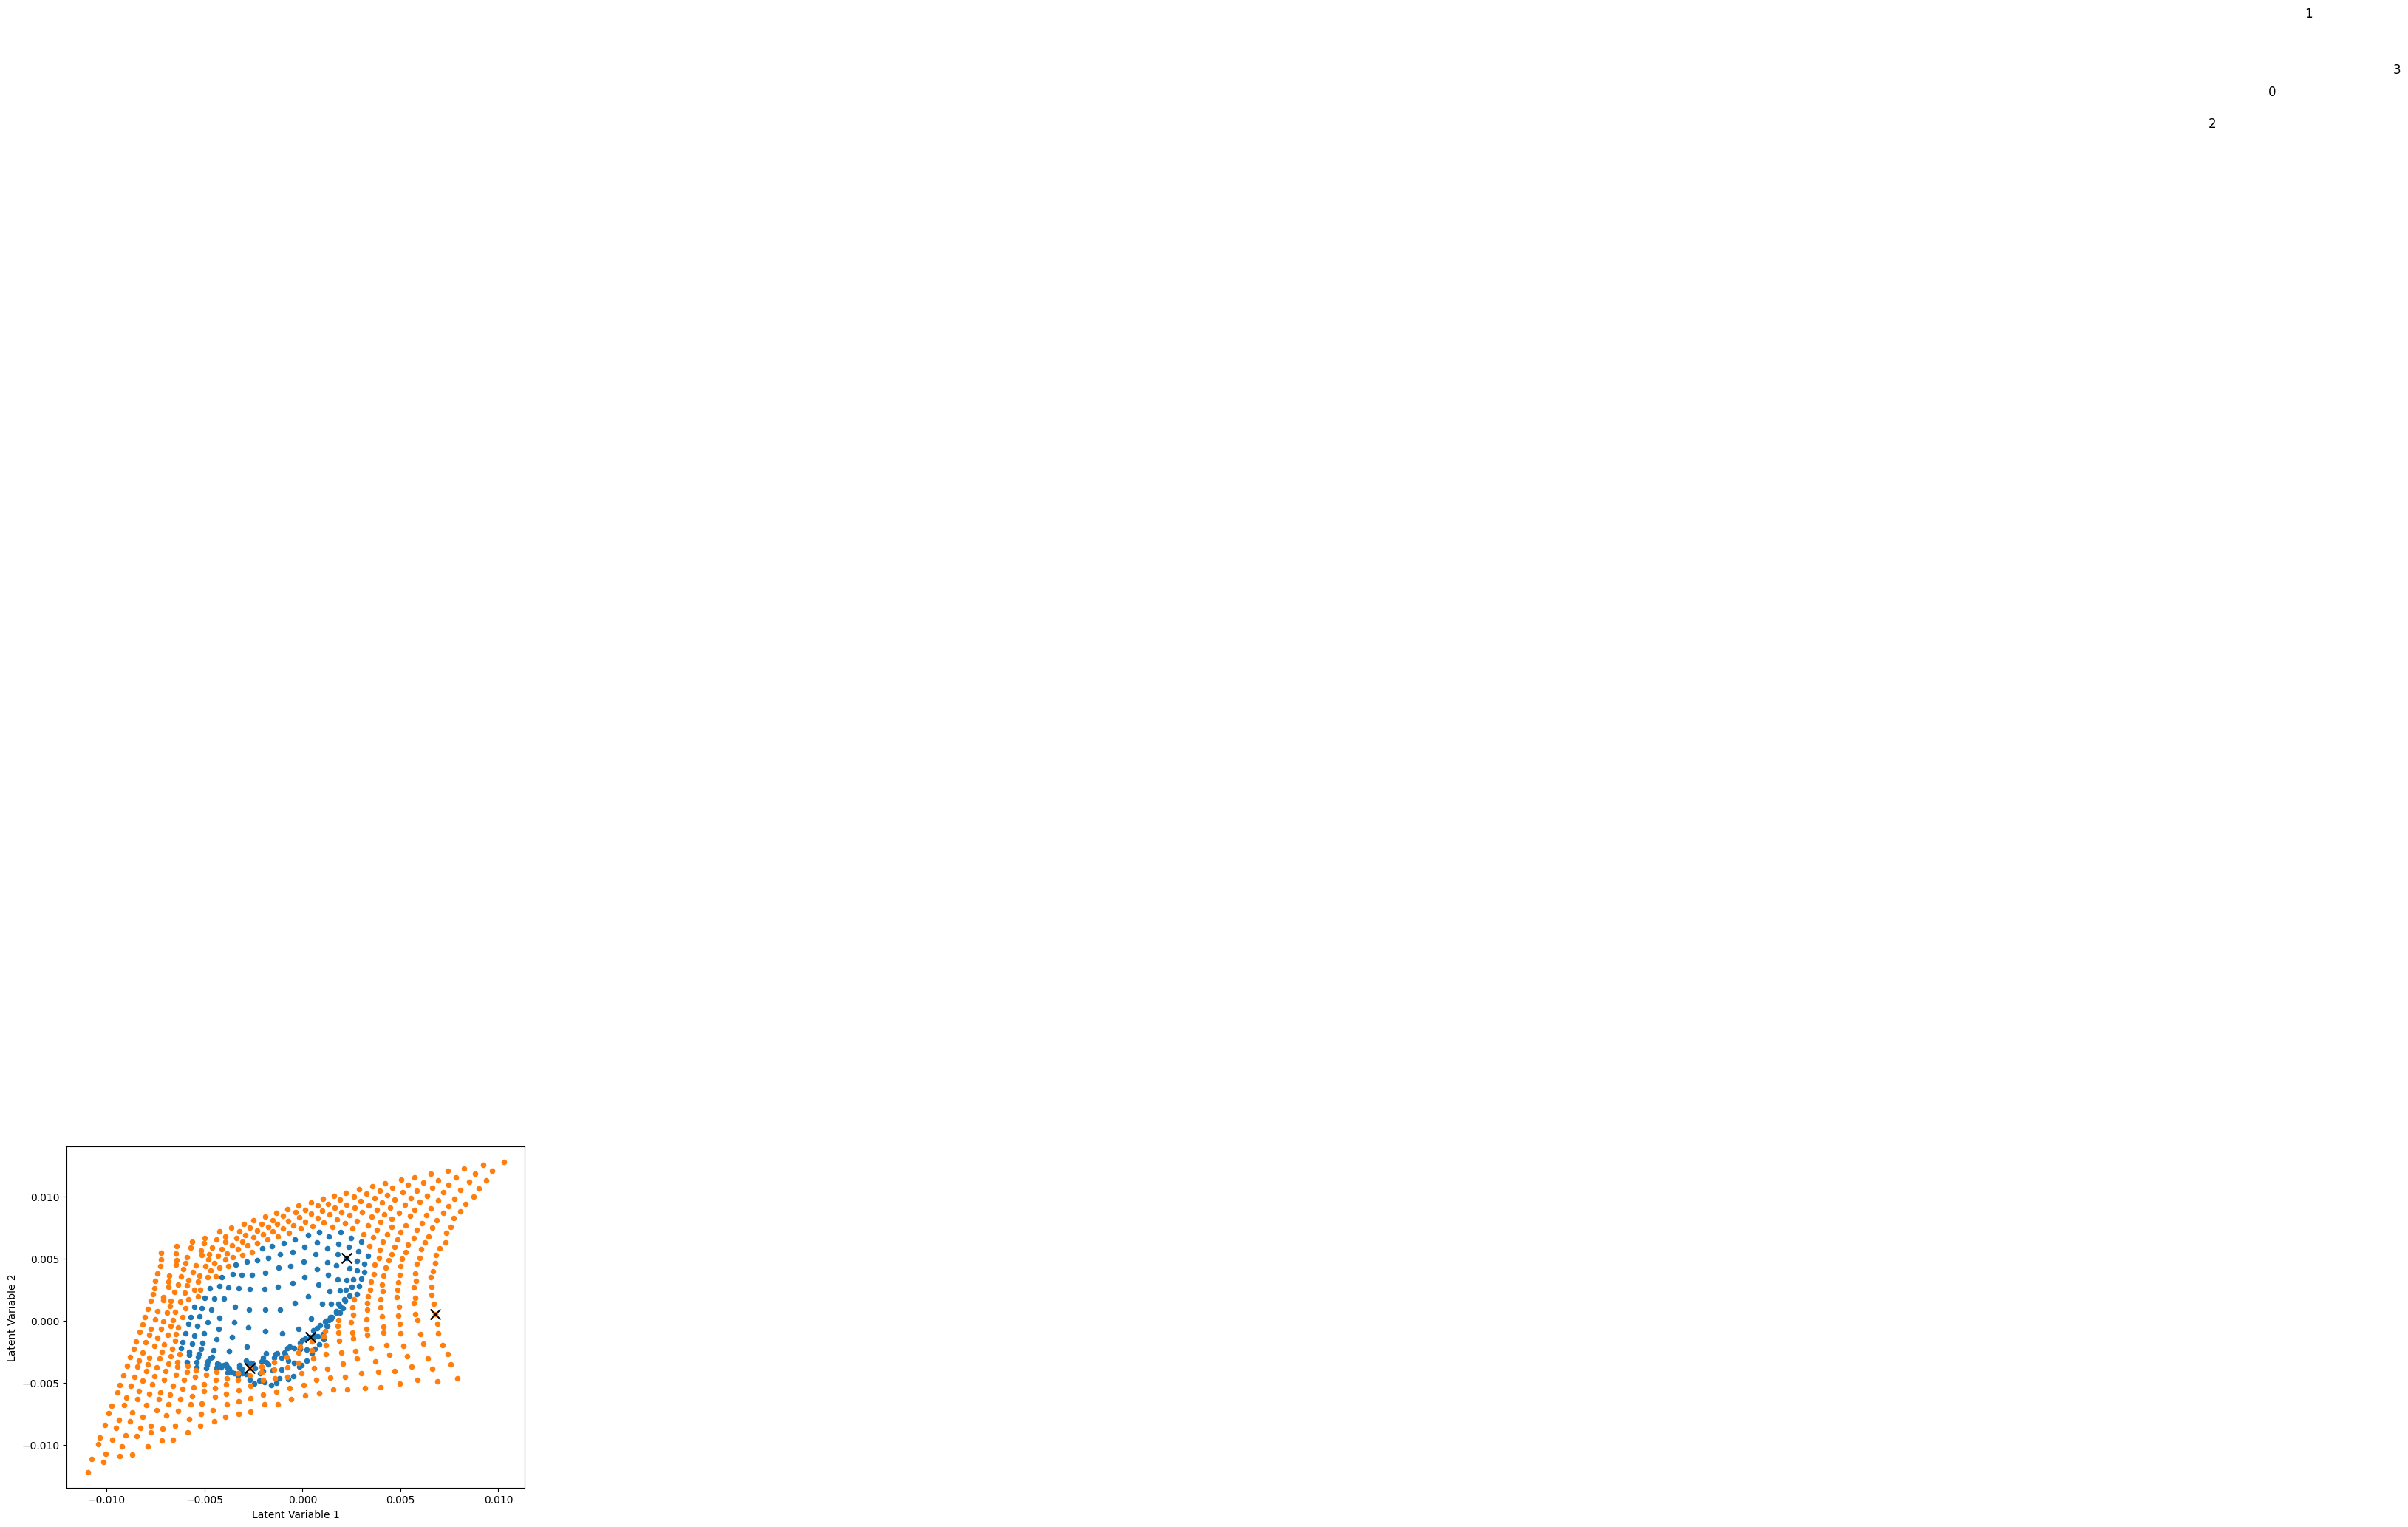

In [42]:
# Set up the plot
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)  # 2D scatter plot
highlited_points = []
for label in np.unique(labels):
    points = latent_means[labels == label]
    ax.scatter(points[:, 0], points[:, 1], s=20, label=f'Label {label}')
    
    # highlight two points
    rand_index = np.random.randint(0,len(points),2)
    highlited_points.append(torch.Tensor(points[rand_index[0]]).unsqueeze(0))
    highlited_points.append(torch.Tensor(points[rand_index[1]]).unsqueeze(0))

ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')

# add text and arrow above highlighted points
for i,point in enumerate(highlited_points):
    ax.scatter(point[0,0], point[0, 1], s=100, c='black', marker='x')
    ax.text(point[0,0]+0.1, point[0,1]+0.1, str(i), fontsize=12,c='black')

# points_to_decode = torch.cat(highlited_points)
# with torch.no_grad():
#     decoded = model_VAE_RBF.VAE.decode(points_to_decode)[0]

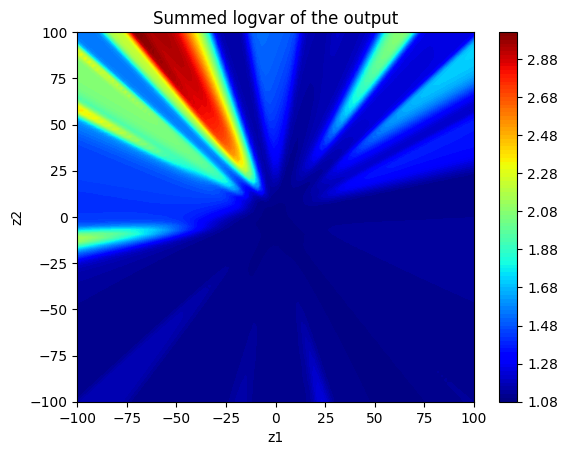

In [43]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=100
x = torch.linspace(min_x-offset,max_x+offset,n)
y = torch.linspace(min_y-offset,max_y+offset,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = model_VAE_RBF.VAE.decode(grid)[1]
    summed_logvar_x = torch.log(torch.sum(torch.exp(logvar_x/2),dim=1))
    #summed_logvar_x = torch.sum(logvar_x,dim=1)
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Summed logvar of the output')
    plt.show()

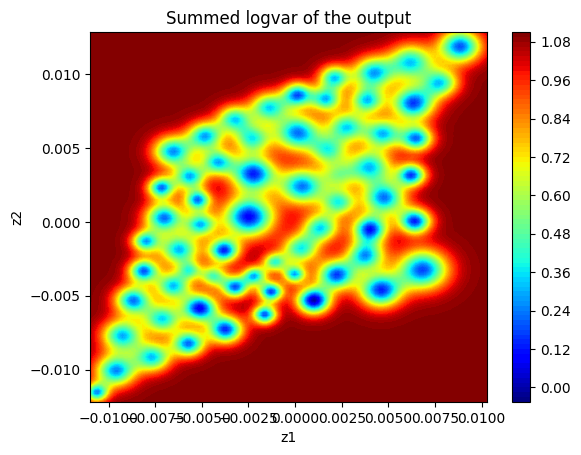

In [44]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=5
x = torch.linspace(min_x,max_x,n)
y = torch.linspace(min_y,max_y,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = model_VAE_RBF.forward_RBF(grid)
    summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Summed logvar of the output')
    plt.show()

In [45]:
latent_means_np = latent_means.detach().numpy()

# The G_mode_parameters is used by the manifold class to compute the metric tensor
G_model_parameters = {'name': 'generator'}
w_counter = 0
b_counter = 0
for name, param in model_VAE_RBF.VAE.named_parameters():
    if ('dec' or 'mu_dec') in name:
        if 'weight' in name:
            key_name = 'W' + str(w_counter)
            G_model_parameters[key_name] = param.detach().numpy()
            w_counter += 1
        elif 'bias' in name:
            key_name = 'b' + str(b_counter)
            G_model_parameters[key_name] = param.detach().numpy().reshape(-1, 1)
            b_counter += 1

G_model_parameters['activation_fun_hidden'] = str(hidden_activation).lower()  # Get the name of activFun e.g. Tanh() -> tanh
G_model_parameters['activation_fun_output'] = str(decoder_output_mu_activation).lower()
G_model_parameters['Wrbf'] = model_VAE_RBF.RBF.W_rbf.detach().numpy()  # The weights for the RBFs (D x K)
G_model_parameters['Crbf'] = model_VAE_RBF.RBF.centers_rbf.detach().numpy()  # The centers for the RBFs (K x d)
G_model_parameters['Grbf'] = model_VAE_RBF.RBF.lambdas_k.detach().numpy()  # * np.ones((K_rbf, 1))  # The precision for the RBFs (K x 1)
G_model_parameters['zeta'] = zeta_rbf  # A small value to prevent division by 0
G_model_parameters['beta'] = 1.0  # This scaling parameter of the metric is updated later

# Construct the manifold
manifold_latent = manifolds.MlpMeanInvRbfVar(G_model_parameters)
# Rescale the metric such that the maximum measure on the data to be 1
beta_rbf = 1 / (np.sqrt(np.linalg.det(manifold_latent.metric_tensor(latent_means_np.T)).max()))
G_model_parameters['beta'] = beta_rbf ** (2 / latent_dim)  # Rescale the pull-back metric
z1min, z2min = latent_means_np.min(0) - 0.5
z1max, z2max = latent_means_np.max(0) + 0.5

/home/tdanielou/Code/MVA/Geometric-Data-Analysis/latent_space_oddity_MVA/core/utils.py:76: RuntimeWarning: invalid value encountered in sqrt
  img[n] = np.sqrt(np.linalg.det(np.squeeze(M[n, :, :])))


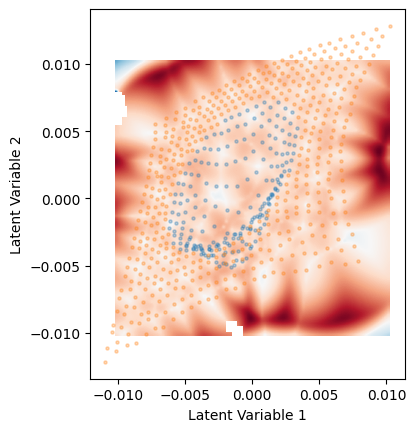

In [46]:
fig, ax = plt.subplots()
utils.plot_measure(manifold_latent, np.linspace(z1min/50, z1max/50, 100), np.linspace(z2min/50, z2max/50, 100))

#utils.my_plot(latent_means_np, c=labels, s=5, alpha=0.3)
for label in np.unique(labels):
    points = latent_means_np[labels == label]
    ax.scatter(points[:, 0], points[:, 1], s=5, label=f'Label {label}',alpha=0.3)
    ax.set_xlabel('Latent Variable 1')
    ax.set_ylabel('Latent Variable 2')

/home/tdanielou/Code/MVA/Geometric-Data-Analysis/latent_space_oddity_MVA/core/utils.py:76: RuntimeWarning: invalid value encountered in sqrt
  img[n] = np.sqrt(np.linalg.det(np.squeeze(M[n, :, :])))


[Initialize Graph] [Processed point: 0/64]


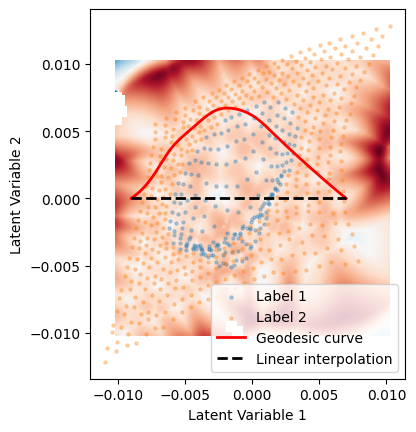

In [48]:
fig, ax = plt.subplots()
utils.plot_measure(manifold_latent, np.linspace(z1min/50, z1max/50, 100), np.linspace(z2min/50, z2max/50, 100))

for label in np.unique(labels):
    points = latent_means_np[labels == label]
    ax.scatter(points[:, 0], points[:, 1], s=5, label=f'Label {label}',alpha=0.3)
    ax.set_xlabel('Latent Variable 1')
    ax.set_ylabel('Latent Variable 2')

# Compute some random curve using a heuristic graph solver
GRAPH_DATA = KMeans(n_clusters=64, n_init=30, max_iter=1000).fit(latent_means_np).cluster_centers_
solver_graph = geodesics.SolverGraph(manifold_latent, data=GRAPH_DATA, kNN_num=5, tol=1e-2)

ind_0, ind_1 = np.random.choice(len(train_dataset), 2, replace=False)
# c0 = latent_means_np[ind_0, :].reshape(-1, 1)
# c1 = latent_means_np[ind_1, :].reshape(-1, 1)

c0 = np.array([[-0.009], [0]])
c1 = np.array([[0.007], [0]])

curve_graph, logmap_graph, curve_length_graph, failed_graph, solution_graph \
    = geodesics.compute_geodesic(solver_graph, manifold_latent, c0, c1)
geodesics.plot_curve(curve_graph, c='r', linewidth=2, label = 'Geodesic curve')
plt.plot([c0[0, 0], c1[0, 0]], [c0[1, 0], c1[1, 0]], 'k--', linewidth=2, label = 'Linear interpolation')
plt.legend()